In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, rdFingerprintGenerator, Draw, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.linalg import lu

In [2]:
df = pd.read_csv('egfr_chembl_w_3d_desc.csv')
df.head(5)

,Molecule ChEMBL ID,Standardized Smiles,pIC50,MolWt,TPSA,nRotB,HBD,HBA,LogP,NumHetAtoms,...,Asphericity,Eccentricity,InertShpFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadGyr,SphIndex
0,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.03,378.216809,75.20,8.0,2.0,7.0,3.21102,7.0,...,0.346792,0.949285,0.000302,0.314416,0.709979,2348.473406,5303.056829,7469.314058,4.469424,0.078888
1,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.07,428.132407,65.97,11.0,2.0,6.0,4.67470,7.0,...,0.515057,0.979596,0.000452,0.200975,0.836380,1849.092420,7695.223512,9200.625574,4.672112,0.082435
2,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.34,386.085457,65.97,8.0,2.0,6.0,3.50440,7.0,...,0.450754,0.970872,0.000518,0.239600,0.777725,1501.590763,4874.070040,6267.084316,4.040084,0.075970
3,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.16,300.001058,50.70,2.0,1.0,4.0,3.53090,5.0,...,0.671818,0.992178,0.001572,0.124831,0.887221,564.497174,4012.100926,4522.097028,3.886738,0.024854
4,CHEMBL405772,Cc1cccc(Nc2ncnc3ccncc23)c1N,7.39,251.117095,76.72,4.0,2.0,5.0,2.65902,5.0,...,0.553633,0.983344,0.001524,0.181754,0.820401,538.390071,2430.184444,2962.192745,3.435186,0.019771


In [3]:
PandasTools.AddMoleculeColumnToFrame(df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

In [4]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
fps = [fpgen.GetFingerprint(x) for x in df['Molecule']]

sim_array = []

for i in range(len(fps)):
    sims = i*[0] + DataStructs.BulkTanimotoSimilarity(fps[i],fps[i:])
    sim_array.append(sims)
    
self_sim = np.diag(np.array([1]*len(fps)))    
sim_array = np.array(sim_array) 
sim_array = sim_array + sim_array.T - self_sim

In [5]:
sim_TSNE = TSNE(n_components = 2, n_iter = 1000)
TSNE_comp = sim_TSNE.fit_transform(sim_array)

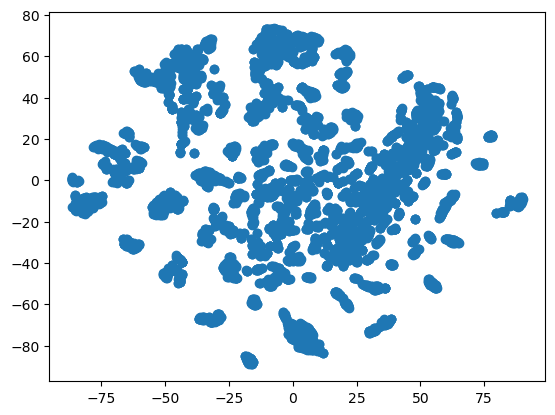

In [6]:
plt.scatter(TSNE_comp[:,0],TSNE_comp[:,1])
plt.savefig('TSNE_plot.png')
plt.show()

In [7]:
TSNE_max = np.amax(TSNE_comp,axis = 0)
TSNE_min = np.amin(TSNE_comp,axis = 0)
scl_TSNE = TSNE_comp/(TSNE_max - TSNE_min)

The average silhouette value for 2 clusters is 0.3659999966621399


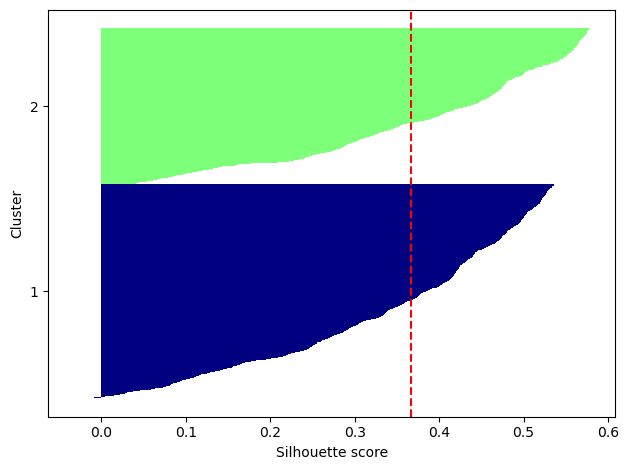

The average silhouette value for 3 clusters is 0.38499999046325684


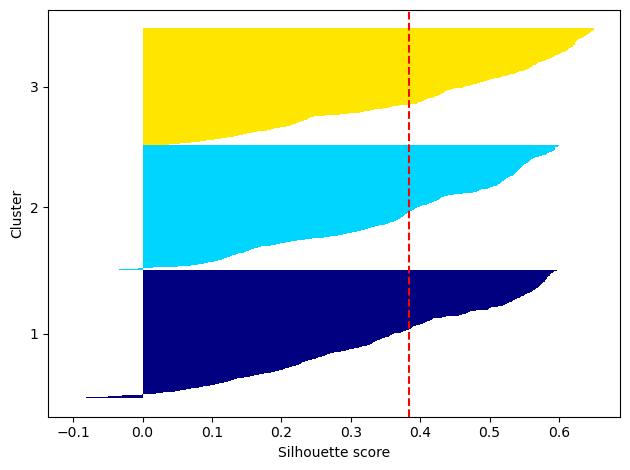

The average silhouette value for 4 clusters is 0.39899998903274536


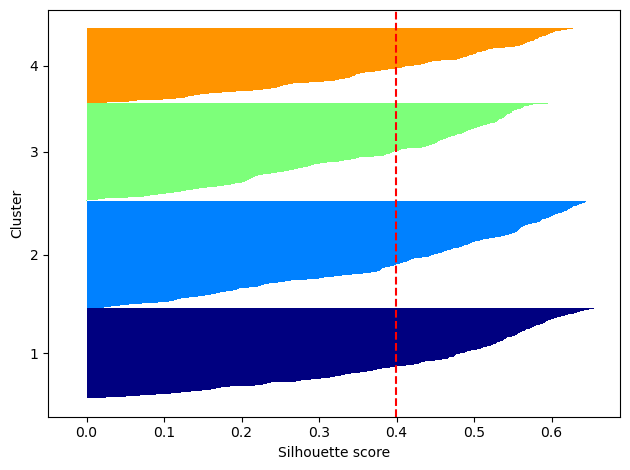

The average silhouette value for 5 clusters is 0.38499999046325684


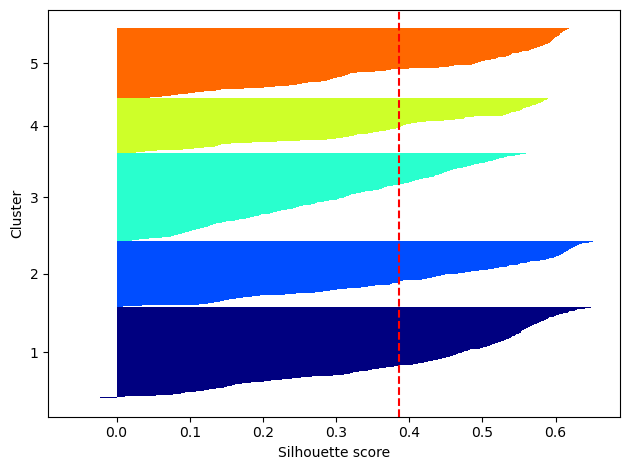

The average silhouette value for 6 clusters is 0.4009999930858612


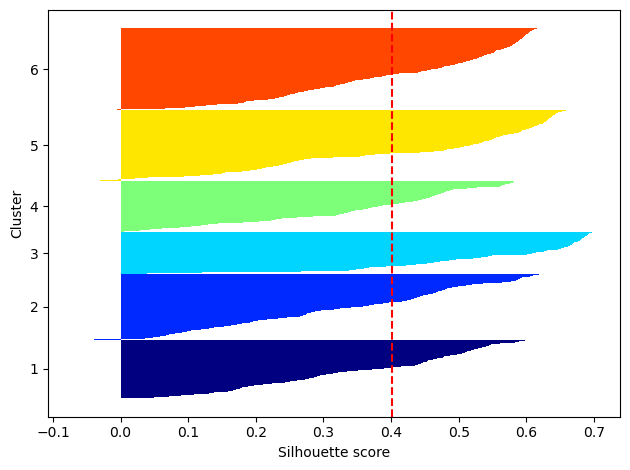

The average silhouette value for 7 clusters is 0.4059999883174896


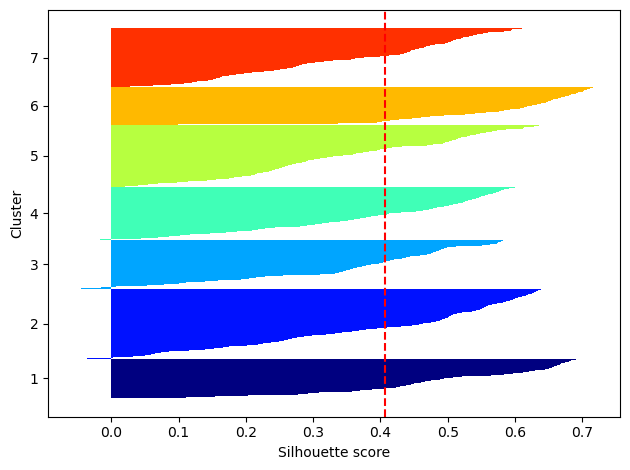

The average silhouette value for 8 clusters is 0.4059999883174896


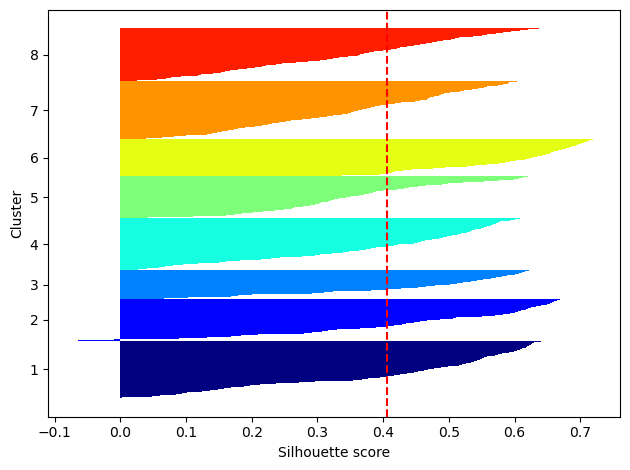

The average silhouette value for 9 clusters is 0.4169999957084656


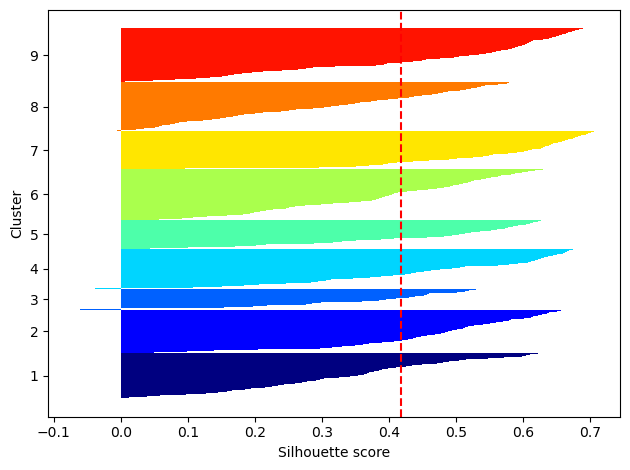

The average silhouette value for 10 clusters is 0.4099999964237213


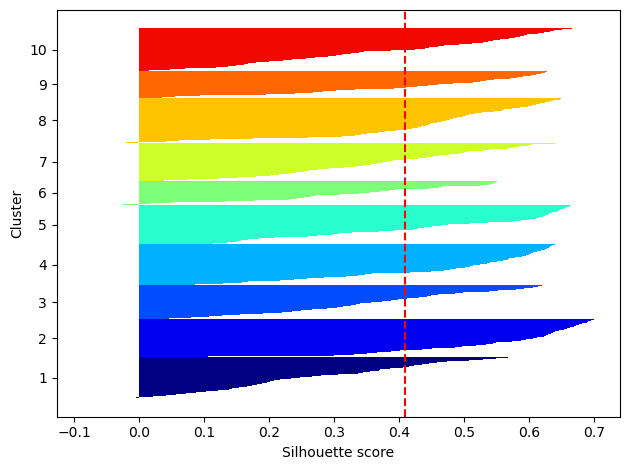

In [9]:
k_choice = list(range(2,11))
km_collection = {} #save y_km

for k in k_choice:
    km = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 0)
    y_km = km.fit_predict(scl_TSNE)
    km_collection[f'{k} clusters'] = y_km
    cluster_labels = np.unique(y_km)
    clust_nums = cluster_labels.shape[0]
    sil_vals = silhouette_samples(scl_TSNE, y_km, metric = 'euclidean')
    y_bottom, y_upper = 0,0
    yticks = []
    
    for i,j in enumerate(cluster_labels):
        j_sil_vals = sil_vals[y_km == j]
        j_sil_vals.sort()
        y_upper += len(j_sil_vals)
        color = cm.jet(float(i)/clust_nums)
        plt.barh(range(y_bottom, y_upper), j_sil_vals, height = 1, edgecolor = 'none', color = color)
        yticks.append((y_bottom + y_upper)/2)
        y_bottom += len(j_sil_vals)
    
    sil_avg = np.mean(sil_vals)
    plt.axvline(sil_avg, color = 'red', linestyle = '--')
    plt.yticks(yticks, cluster_labels + 1)
    print(f'The average silhouette value for {k} clusters is {round(sil_avg,3)}')
    plt.ylabel('Cluster')
    plt.xlabel("Silhouette score")
    plt.tight_layout()
    plt.savefig(f'{k}_clusters_TSNE.png')
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

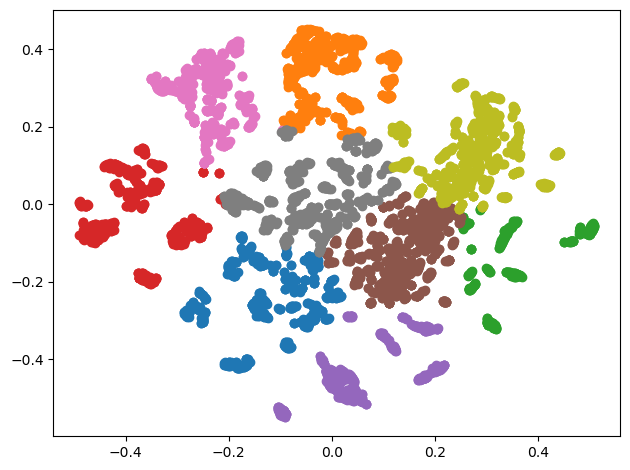

In [12]:
km_collection['9 clusters']

for c in range(9):
    choice = km_collection['9 clusters']
    plt.scatter(scl_TSNE[choice == c,0], scl_TSNE[choice == c, 1])
plt.tight_layout()
plt.savefig(f'TSNE_cluster_labelled.png')
plt.show

In [16]:
df['Cluster label'] = km_collection['9 clusters']
PandasTools.AddMoleculeColumnToFrame(df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

In [17]:
for i in df.index:
    mol = df.loc[i,'Molecule']
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mol))
    except:
        scaff = None
    df.loc[i,'Scaffold'] = scaff   

In [18]:
def get_sim_array(fps):
    sim_array = []
    for i in range(len(fps)):
        sims = i*[0] + DataStructs.BulkTanimotoSimilarity(fps[i],fps[i:])
        sim_array.append(sims)

    #Matrix math
    self_sim = np.diag(np.array([1]*len(fps)))    
    sim_array = np.array(sim_array)
    sim_array[sim_array != 1] = 0 
    sim_array = sim_array + sim_array.T - self_sim
    return sim_array

def common_scaffold(red_matrix, ind_list):
    shared_scaff = {}
    for i in range(red_matrix.shape[0]):
        if np.sum(red_matrix[i,:]) > 0:
            common_ind = np.where(red_matrix[i,:] == 1, ind_list, -1)
            common_ind = common_ind[common_ind >= 0]
            shared_scaff[i] = list(common_ind)
            
    return shared_scaff 

In [21]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
fps = [fpgen.GetFingerprint(x) for x in df['Scaffold']]

cluster_groups = {}

for label,group in df.groupby('Cluster label'):
    ind = list(group.index)
    fps = [fpgen.GetFingerprint(x) for x in df.loc[ind,'Scaffold']]
    sim_array = get_sim_array(fps)
    p,l,u = lu(sim_array)
    red_matrix = p@u
    repeats = common_scaffold(red_matrix, ind)
    cluster_groups[f'cluster_{label}'] = repeats

In [22]:
for label in cluster_groups:
    scaffs = []
    counts = []
    for scaffold in cluster_groups[label]:
        ind = cluster_groups[label][scaffold][0]
        scaff_count = len(cluster_groups[label][scaffold])
        scaffs.append(df.loc[ind,'Scaffold'])
        counts.append(str(scaff_count))
        
    print(f'{label}, {len(counts)}')
    img = Draw.MolsToGridImage(scaffs, legends = counts, maxMols = 70, subImgSize = (500,500), returnPNG = False)
    img.save(f'TSNE_{label}.png')

cluster_0, 38
cluster_1, 15
cluster_2, 14
cluster_3, 20
cluster_4, 6
cluster_5, 43
cluster_6, 17
cluster_7, 29
cluster_8, 58
